In [1]:
from importlib import reload
import sys
sys.path.insert(0, '../')

# sys.path.remove("/home/users/yixiuz/.local/lib/python3.9/site-packages")
sys.path.append("/home/groups/swl1/yixiuz/torch_fid/lib/python3.9/site-packages")
sys.path.append("/home/groups/swl1/yixiuz/torch_fid/bin")

In [2]:
# reload(sampling)

In [3]:
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import ml_collections

# Choose the config file to load depending on the experiment
import config.eval.countdown as eval_config
# import config.eval.genes_base as eval_config
# import config.eval.genes_hollow as eval_config
# import config.eval.aemet_hollow as eval_config

import lib.utils.bookkeeping as bookkeeping
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import lib.utils.utils as utils
import lib.models.models as models
import lib.models.model_utils as model_utils
import lib.datasets.datasets as datasets
import lib.datasets.dataset_utils as dataset_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils

%matplotlib inline

eval_cfg = eval_config.get_config()
train_cfg = bookkeeping.load_ml_collections(Path(eval_cfg.train_config_path))

for item in eval_cfg.train_config_overrides:
    utils.set_in_nested_dict(train_cfg, item[0], item[1])

S = train_cfg.data.S

device = torch.device(eval_cfg.device)
# device = torch.device('cpu')

model = model_utils.create_model(train_cfg, device)

loaded_state = torch.load(Path(eval_cfg.checkpoint_path),
    map_location=device)

modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
model.load_state_dict(modified_model_state)

model.eval()

dataset = dataset_utils.get_dataset(eval_cfg, device)
data = dataset.data

In [4]:
from eval import count_mistakes, get_dist, hellinger, eval_mse_stats
from tqdm import tqdm

In [83]:
def take_euler_step(in_x, rates, h):
    N, D = in_x.shape
    
    rates *= h
    
    # Sum of the rates for each row
    sum_rates = torch.sum(rates, dim=-1)
    
    # Transition logit: log(1 - exp(-rates)) = log(-expm1(-rates))
    transition_logit = torch.log(-torch.expm1(-rates))
    
    # Set the diagonal of transition_logit to -sum_rates
    transition_logit[torch.arange(N, device=device).repeat_interleave(D),
                     torch.arange(D, device=device).repeat(N),
                     in_x.long().flatten()] = -sum_rates.flatten()
    
    # Use categorical sampling to select the next state
    dist = torch.distributions.categorical.Categorical(logits=transition_logit)
    out = dist.sample().long()
    
    return out

In [22]:
from lib.sampling.sampling import get_initial_samples, compute_backward

In [20]:
@sampling_utils.register_sampler
class PCEulerAbsorbingInformed():
    def __init__(self, cfg):
        self.cfg = cfg

    def sample(self, model, N, num_intermediates):
        t = 1.0

        D = np.prod(self.cfg.data.shape)
        S = self.cfg.data.S
        scfg = self.cfg.sampler
        num_steps = scfg.num_steps
        min_t = scfg.min_t
        eps_ratio = scfg.eps_ratio
        num_corrector_steps = scfg.num_corrector_steps
        corrector_step_size_multiplier = scfg.corrector_step_size_multiplier
        corrector_entry_time = scfg.corrector_entry_time
        
        if scfg.balancing_function == "barker":
            balancing_function = lambda score: score / (1 + score) 
        elif scfg.balancing_function == "mpf":
            balancing_function = lambda score: torch.sqrt(score)
        elif scfg.balancing_function == "birthdeath":
            balancing_function = None
        else:
            print("Balancing function not found: " + scfg.balancing_function)
            return
        
        device = model.device

        initial_dist = scfg.initial_dist
        if initial_dist == 'gaussian':
            initial_dist_std = model.Q_sigma
        else:
            initial_dist_std = None

        with torch.no_grad():
            x = get_initial_samples(N, D, device, S, initial_dist,
                initial_dist_std)

            h = 1.0 / num_steps # approximately 
            ts = np.linspace(1.0, min_t+h, num_steps)
            save_ts = ts[np.linspace(0, len(ts)-2, num_intermediates, dtype=int)]

            x_hist = []
            x0_hist = []
            c_rate_hist = []

            for idx, t in tqdm(enumerate(ts[0:-1])):

                h = ts[idx] - ts[idx+1]

                def get_rates(in_x, in_t):
                    qt0 = model.transition(in_t * torch.ones((N,), device=device)) # (N, S, S)
                    rate = model.rate(in_t * torch.ones((N,), device=device)) # (N, S, S)

                    p0t = F.softmax(model(in_x, in_t * torch.ones((N,), device=device)), dim=2) # (N, D, S)

                    denom_x = torch.ones_like(in_x) * (S-1)

                    forward_rates, transpose_forward_rates, reverse_rates, x_0max, scores = compute_backward(qt0, rate, p0t, in_x, denom_x=denom_x, eps=eps_ratio)
                    
                    mask_positions = in_x == (S-1)
                    nonmask_positions = ~mask_positions

                    backward_score_to_curr = scores[
                        torch.arange(N, device=device).repeat_interleave(D),
                        torch.arange(D, device=device).repeat(N),
                        in_x.long().flatten()
                    ].view(N,D)
                    forward_score_from_curr = 1 / (backward_score_to_curr * nonmask_positions + mask_positions)
                    forward_score_from_curr *= nonmask_positions

                    scores = scores * mask_positions.unsqueeze(2)
                    scores[:,:,S-1] = forward_score_from_curr
                    
                    forward_rates[
                        torch.arange(N, device=device).repeat_interleave(D),
                        torch.arange(D, device=device).repeat(N),
                        in_x.long().flatten()
                    ] = 0.0 
                    reverse_rates[
                        torch.arange(N, device=device).repeat_interleave(D),
                        torch.arange(D, device=device).repeat(N),
                        in_x.long().flatten()
                    ] = 0.0 
                    
                    return forward_rates, transpose_forward_rates, reverse_rates, x_0max, scores

                _, _, reverse_rates, x_0max, _ = get_rates(x, t)

                if t in save_ts:
                    x_hist.append(x.detach().cpu().numpy())
                    x0_hist.append(x_0max.detach().cpu().numpy())

                x = take_euler_step(x, reverse_rates, h)

                if t <= corrector_entry_time:
                    for cstep in range(num_corrector_steps):
                        forward_rates, transpose_forward_rates, reverse_rates, _, scores = get_rates(x, t-h)
                        if balancing_function is None:
                            # We're using the default corrector
                            # which corresponds to birth-death Stein operator
                            corrector_rate = transpose_forward_rates + reverse_rates
                        else:
                            # We removed the one half here because it makes more sense for the absorbing
                            corrector_rate = (transpose_forward_rates + forward_rates) * balancing_function(scores)
                            
                        corrector_rate[
                            torch.arange(N, device=device).repeat_interleave(D),
                            torch.arange(D, device=device).repeat(N),
                            x.long().flatten()
                        ] = 0.0

                        if cstep == 0 and t in save_ts:
                            c_rate_hist.append(corrector_rate.detach().cpu().numpy())

                        x = take_euler_step(x, corrector_rate, 
                            corrector_step_size_multiplier * h)
                elif t in save_ts:
                    c_rate_hist.append(np.zeros((N, D, S)))

            x_hist = np.array(x_hist).astype(int)
            x0_hist = np.array(x0_hist).astype(int)
            c_rate_hist = np.array(c_rate_hist)

            p_0gt = F.softmax(model(x, min_t * torch.ones((N,), device=device)), dim=2) # (N, D, S)
            x_0max = torch.max(p_0gt, dim=2)[1]

            mask_positions = x == (S-1)
            nonmask_positions = ~mask_positions
            samples = nonmask_positions * x + mask_positions * x_0max
            
            hist = {
                "x": x_hist,
                "x0": x0_hist,
                "rc": c_rate_hist
            }
            
            return samples.detach().cpu().numpy().astype(int), hist


In [79]:
@sampling_utils.register_sampler
class PCKGillespies():
    def __init__(self, cfg):
        self.cfg =cfg

    def sample(self, model, N, num_intermediates=0):
        t = 1.0
        D = np.prod(self.cfg.data.shape)
        S = self.cfg.data.S
        scfg = self.cfg.sampler
        min_t = scfg.min_t
        eps_ratio = scfg.eps_ratio
        initial_dist = scfg.initial_dist
        
        num_corrector_steps = scfg.num_corrector_steps
        corrector_step_size_multiplier = scfg.corrector_step_size_multiplier
        corrector_entry_time = scfg.corrector_entry_time
        
        updates_per_eval = scfg.updates_per_eval

        if scfg.balancing_function == "barker":
            balancing_function = lambda score: score / (1 + score) 
        elif scfg.balancing_function == "mpf":
            balancing_function = lambda score: torch.sqrt(score)
        elif scfg.balancing_function == "birthdeath":
            balancing_function = None
        else:
            print("Balancing function not found: " + scfg.balancing_function)
            return
        
        if initial_dist == 'gaussian':
            initial_dist_std  = model.Q_sigma
        else:
            initial_dist_std = None
        device = model.device

        # Now the batch is not syncronized anymore
        ts = t * torch.ones((N,), device=device)
        update_mask = ts > min_t
        num_updates = 0
        
        with torch.no_grad():
            x = get_initial_samples(N, D, device, S, initial_dist,
                initial_dist_std)
            
            pbar = tqdm(total=D)
            while num_updates < D:

                # Compute backward transition rate
                qt0 = model.transition(ts) # (N, S, S)
                rate = model.rate(ts) # (N, S, S)

                p0t = F.softmax(model(x, ts), dim=2) # (N, D, S)

                Rf, RfT, Rb, x_0max, scores = compute_backward(qt0, rate, p0t, x)
                # Rb: (N, D, S)
                Rb[torch.arange(N, device=device).repeat_interleave(D),
                   torch.arange(D, device=device).repeat(N),
                   x.long().flatten()] = eps_ratio
            
                # Compute total rate (N, D)
                Rb_sum = torch.sum(Rb, axis=2)
                # Sample a holding time (N, D)
                taus = torch.distributions.Exponential(Rb_sum).sample()
                # Find the position of the shortest holding time for each dimension (N,)
                ids_sorted = torch.argsort(taus, axis=1)
                dts = torch.zeros((N,), device=device)
                
                for update in range(updates_per_eval):
                    # Make one round of updates
                    ids = ids_sorted[:, update]
                    # (N,)
                    dts = taus[torch.arange(N, device=device), ids] - dts

                    # Rates given the dimensions of transition (N, S)
                    rates_single = Rb[torch.arange(N, device=device),ids]
                    # Total rate given the dimensions of transition (N, 1)
                    rates_sum_single = torch.unsqueeze(Rb_sum[torch.arange(N, device=device),ids], 1)
                    # The targets of transition (N,)
                    updates = torch.multinomial(rates_single / rates_sum_single, 1)[:,0]
                    # Update ts
                    update_mask = update_mask & ((ts - dts * update_mask) > min_t)
                    ts -= dts * update_mask
                    # Update x
                    original = x[torch.arange(N, device=device), ids]
                    x[torch.arange(N, device=device), ids] = updates * update_mask + original * (~update_mask)
                    num_updates += 1
                    pbar.update(1)
                    
                def get_rates(in_x, in_t):
                    qt0 = model.transition(in_t) # (N, S, S)
                    rate = model.rate(in_t) # (N, S, S)

                    p0t = F.softmax(model(in_x, in_t), dim=2) # (N, D, S)

                    denom_x = torch.ones_like(in_x) * (S-1)

                    forward_rates, transpose_forward_rates, reverse_rates, x_0max, scores = compute_backward(qt0, rate, p0t, in_x, denom_x=denom_x, eps=eps_ratio)
                    
                    mask_positions = in_x == (S-1)
                    nonmask_positions = ~mask_positions

                    backward_score_to_curr = scores[
                        torch.arange(N, device=device).repeat_interleave(D),
                        torch.arange(D, device=device).repeat(N),
                        in_x.long().flatten()
                    ].view(N,D)
                    forward_score_from_curr = 1 / (backward_score_to_curr * nonmask_positions + mask_positions)
                    forward_score_from_curr *= nonmask_positions

                    scores = scores * mask_positions.unsqueeze(2)
                    scores[:,:,S-1] = forward_score_from_curr
                    
                    forward_rates[
                        torch.arange(N, device=device).repeat_interleave(D),
                        torch.arange(D, device=device).repeat(N),
                        in_x.long().flatten()
                    ] = 0.0 
                    reverse_rates[
                        torch.arange(N, device=device).repeat_interleave(D),
                        torch.arange(D, device=device).repeat(N),
                        in_x.long().flatten()
                    ] = 0.0 
                    
                    return forward_rates, transpose_forward_rates, reverse_rates, x_0max, scores

                if num_updates >= (1-corrector_entry_time) * D:
                    
                    h = 1/D
                    
                    for cstep in range(num_corrector_steps):
                        forward_rates, transpose_forward_rates, reverse_rates, _, scores = get_rates(x, ts) # ts-h?
                        if balancing_function is None:
                            # We're using the default corrector
                            # which corresponds to birth-death Stein operator
                            corrector_rate = transpose_forward_rates + reverse_rates
                        else:
                            # We removed the one half here because it makes more sense for the absorbing
                            corrector_rate = (transpose_forward_rates + forward_rates) * balancing_function(scores)
                        # Only update dimensions with 
                        corrector_rate *= update_mask.unsqueeze(1).unsqueeze(1)
                            
                        corrector_rate[
                            torch.arange(N, device=device).repeat_interleave(D),
                            torch.arange(D, device=device).repeat(N),
                            x.long().flatten()
                        ] = 0.0

                        x = take_euler_step(x, corrector_rate, 
                            corrector_step_size_multiplier * h)

            p_0gt = F.softmax(model(x, min_t * torch.ones((N,), device=device)), dim=2) # (N, D, S)
            x_0max = torch.max(p_0gt, dim=2)[1]

            mask_positions = x == (S-1)
            nonmask_positions = ~mask_positions
            samples = nonmask_positions * x + mask_positions * x_0max
            
            out = {
                "ts": ts.cpu().numpy()
            }
            
            return samples.detach().cpu().numpy().astype(int), out

In [61]:
results = []

In [80]:
step_sizes = [.1, .2, .5, 1., 2., 4., 10., 20.]
# step_sizes = [.2, .3, .4]

In [86]:
tqdm._instances.clear()

num_repeats = 1

sample_size = 100

# method = "euler"
# method = "tauleaping"
method = "gillespies"

# corrector = "mpf"
# corrector = "barker"
corrector = "birthdeath"

updates_per_eval = 3

# Generic corrector fields
eval_cfg.sampler.num_corrector_steps = 1
eval_cfg.sampler.corrector_entry_time = 0.9

if method == "gillespies":
    eval_cfg.sampler.name = "PCKGillespies"
    eval_cfg.sampler.updates_per_eval = updates_per_eval
    eval_cfg.sampler.balancing_function = corrector
elif method == "tauleaping":
    eval_cfg.sampler.name = "PCTauLeapingAbsorbingInformed"
    eval_cfg.sampler.num_steps = 100
#     eval_cfg.sampler.corrector_step_size_multiplier = .1
#     eval_cfg.sampler.balancing_function = "birthdeath"
#     eval_cfg.sampler.corrector_step_size_multiplier = 1.
#     eval_cfg.sampler.balancing_function = "barker"
    eval_cfg.sampler.corrector_step_size_multiplier = .5
    eval_cfg.sampler.balancing_function = corrector
elif method == "euler":
    eval_cfg.sampler.name = "PCEulerAbsorbingInformed"
    eval_cfg.sampler.num_steps = 100
    eval_cfg.sampler.balancing_function = corrector
else:
    assert(False)

# sampler = sampling_utils.get_sampler(eval_cfg)

print(f"Tuning hyperparameters for corrector: {corrector} and method: {method}")

for _ in range(num_repeats):
    
    for step_size_mult in step_sizes:
    
        eval_cfg.sampler.corrector_step_size_multiplier = step_size_mult
        print(f"Testing step size: {step_size_mult}")
        sampler = sampling_utils.get_sampler(eval_cfg)
    
        samples, out = sampler.sample(model, sample_size, 0)

        data_flat = dataset.data.flatten().cpu().numpy()
        h_dist = hellinger(data_flat, samples.flatten(), eval_cfg.data.S)
        error_rate = count_mistakes(samples)

        D = eval_cfg.data.shape[0]
        if method == "gillespies":
            nfe = D / updates_per_eval
        elif method == "tauleaping":
            nfe = eval_cfg.sampler.num_steps
        nfe += nfe * eval_cfg.sampler.corrector_entry_time * eval_cfg.sampler.num_corrector_steps

        new_result = {
                    'method': method,
                    'g_steps': 0 if method != "gillespies" else updates_per_eval,
                    'tau_steps': 0 if method != "tauleaping" else eval_cfg.sampler.num_steps,
                    'use_corrector': eval_cfg.sampler.corrector_entry_time > 0 
                                 and eval_cfg.sampler.num_corrector_steps > 0,
                    'corrector': eval_cfg.sampler.balancing_function,
                    'c_stepsize': eval_cfg.sampler.corrector_step_size_multiplier,
                    'c_steps': eval_cfg.sampler.num_corrector_steps,
                    'nfe': nfe,
                    'h_dist': h_dist,
                    'error_rate': error_rate,

                    'samples': samples,

                }
        print(f"Hellinger: {new_result['h_dist']}, error rate: {new_result['error_rate']}")
        results.append(new_result)

Tuning hyperparameters for corrector: birthdeath and method: gillespies
Testing step size: 0.1


258it [00:08, 29.48it/s]                         


Hellinger: 0.0334877442199409, error rate: 0.02296875
Testing step size: 0.2


258it [00:08, 29.47it/s]                         


Hellinger: 0.016116940670690322, error rate: 0.0223046875
Testing step size: 0.5


258it [00:08, 29.60it/s]                         


Hellinger: 0.02645498146704124, error rate: 0.0212109375
Testing step size: 1.0


258it [00:08, 28.99it/s]                         


Hellinger: 0.029540773299965788, error rate: 0.0156640625
Testing step size: 2.0


258it [00:08, 29.54it/s]                         


Hellinger: 0.031323423270572345, error rate: 0.0149609375
Testing step size: 4.0


258it [00:08, 29.45it/s]                         


Hellinger: 0.037885873158697056, error rate: 0.0136328125
Testing step size: 10.0


258it [00:08, 29.47it/s]                         


Hellinger: 0.02573731653153831, error rate: 0.008203125
Testing step size: 20.0


258it [00:08, 29.46it/s]                         


Hellinger: 0.034335337180407974, error rate: 0.0059765625


In [72]:
data_sample = data[0].cpu().numpy().astype(int)

In [8]:
i = 0 

In [19]:
ours_samples = results[-1]["samples"]
# theirs_samples = results[-2]["samples"]

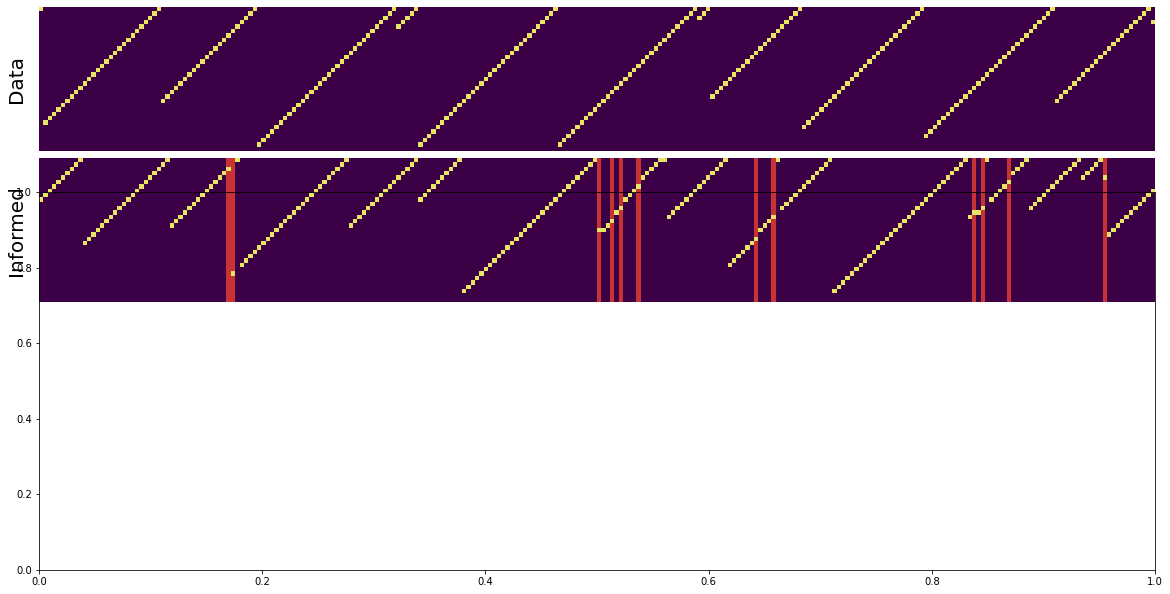

In [18]:
def colorize(arr, err):
    pos_color = np.array([230, 230, 100])
    neg_color = np.array([60, 0, 70])
    err_color = np.array([200, 50, 50])
    
    colored = (1 - arr)[..., None] * neg_color[None, None] * (1 - err)[None, :, None]\
            + (1 - arr)[..., None] * err_color[None, None] * err[None, :, None]\
            + arr[..., None] * pos_color[None, None]
        
    return colored

def plot_countdown_seq(ax, seq, label=""):
    S = 33
    L = 256
    
    err_mask = ((seq[:-1] - seq[1:]) != 1) * (seq[:-1] != 0)
    err_mask = np.insert(err_mask, -1, False)
    
    seq = F.one_hot(seq, S).T
    seq = colorize(seq, err_mask)
    
    ax.imshow(seq)
    ax.axis("off")
    ax.text(-0.02, 0.5, label, va='center', ha='center', rotation='vertical', 
            fontsize=20, transform=ax.transAxes)
    
    ax.set_ylabel(label)
    
i = np.random.randint(100)
fig, axes = plt.subplots(3, 1, figsize=(20,12.5))
plt.subplots_adjust(hspace=-.6)
fig.patch.set_facecolor('none')
axes[0].patch.set_facecolor('none')
axes[1].patch.set_facecolor('none')
axes[2].patch.set_facecolor('none')
# plot_countdown_seq(axes[2], torch.tensor(theirs_samples[i]), "Uninformed")
plot_countdown_seq(axes[1], torch.tensor(ours_samples[i]), "Informed")
plot_countdown_seq(axes[0], torch.tensor(data_sample), "Data")

fig.savefig('countdown_samples_comp.pdf', dpi=300, bbox_inches='tight')

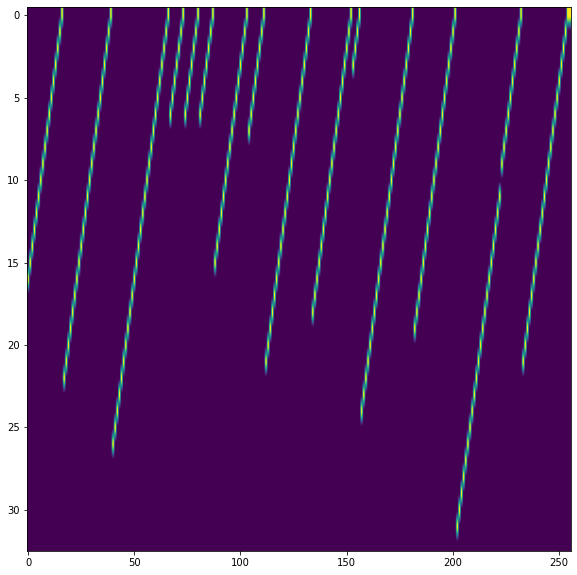

In [22]:
i += 1
plt.figure(figsize=(10,10))
plt.imshow(F.one_hot(torch.tensor(samples[i]), S).T, aspect=256/S)